In [16]:
import sys
from pathlib import Path

import numpy as np
import polars as pl
import lightgbm as lgb

work_path = "/home/haselab/Documents/tat/Research/"
sys.path.append(f"{work_path}app/torch_libs/")

from run_manager_new import RunManager, RunsManager, RunViewer

In [17]:
path_total = Path("/home/haselab/Documents/tat/Research/app/sakana_ml/level9_ml/wkdat_240425_modified.csv")
df = pl.read_csv(path_total, infer_schema_length=1500)


In [18]:
def preprocess(df):
# x, yともに適用する処理
# nullが10以上ある行をdrop
# df = df.with_columns(pl.Series([row.count(None) for row in df.iter_rows()]).alias("null_count")).filter(pl.col("null_count") < 10).drop("null_count")

# x, yそれぞれに適用する処理
# df = df.select(~ pl.selectors.by_name("Tmp"))

    x = df.select(pl.exclude("acceptedNameUsageID"))
    x = x.select(pl.exclude("Scientific name"))
    x = x.select(~ pl.selectors.ends_with("records"))
    # x = x.select(~ pl.selectors.ends_with("ID"))

    x = x.select(pl.exclude("Test_dat"))
    x = x.select(pl.exclude(["Tmp", "IUCN", "Stock status"]))
    x = x.select(pl.exclude(["ICCAT Fisheries", "LL", "PS", "Others"]))
    
    # x = x.select(pl.exclude(pl.Utf8))
    x = x.with_columns(
        pl.when(pl.col(pl.Utf8).is_null())
        .then(pl.lit(0))
        .when(pl.col(pl.Utf8) == "Y")
        .then(pl.lit(1))
        .name.keep()
    )

    # x = x.select(~ pl.selectors.contains("Max_M"))
    # x = x.select(~ pl.selectors.contains("Max_F"))

    # x = x.select([col_name for col_name in x.columns if x[col_name].null_count() <=100 or "associate" in col_name.lower()])

    ys = df.select(["LL", "PS", "Others"])

    # NとYを0, 1に置き換え
    ys = ys.with_columns(
        pl.when(pl.all().is_null())
        .then(pl.lit(0))
        .when(pl.all() == "Y")
        .then(pl.lit(1))
        .name.keep()
    )
    
    return x, ys

In [19]:
df_train = df.filter(pl.col("Test_dat") == "Y")
df_test = df.filter(pl.col("Test_dat").is_null())

x_train, ys_train = preprocess(df_train)
x_test, ys_test = preprocess(df_test)

# display(x_train)
# display(ys_train)
# display(x_test)
# display(ys_test)

# display(x_train.columns)
# display(ys_train.columns)



In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from scipy.optimize import minimize

# テストデータの評価
class Result:
    def __init__(self, val, proba, optimize=False):
        self.val = val
        self.proba = proba

        if optimize:
            def f1_opt(x):
                return -f1_score(self.val, self.proba[:, 1] >= x)
            result = minimize(f1_opt, x0=np.array([0.5]), method="Nelder-Mead")
            threshold = result["x"].item()
            self.pred = self.proba[:, 1] >= threshold
            self.th = threshold
        else:
            self.pred = proba.argmax(axis=1)
            self.th = 0.5

    def acc(self):
        return accuracy_score(self.val, self.pred)

    def f1(self):
        return f1_score(self.val, self.pred, average="macro") 

    def auc(self):
        return roc_auc_score(self.val, self.pred)
    
    def logloss(self):
        return log_loss(self.val, self.proba)

    def cm(self):
        return confusion_matrix(self.val, self.pred)


    # def acc(self):
    #     return getattr(self, "acc_tmp", self.acc_tmp := accuracy_score(self.val, self.pred))

    # def acc(self):
    #     attrname = "acc_tmp"
    #     try:
    #         return getattr(self, attrname)
    #     except:

    #         score = accuracy_score(self.val, self.pred)

    #         setattr(self, attrname, score)
    #         return getattr(self, attrname)


class Scores:
    def __init__(self):
        self.score_dict = dict()
        
    def __getitem__(self, index):
        return self.score_dict.setdefault(index, [])
    
    def __setitem__(self, key, value):
        self.score_dict[key] = value
        return self
        
    def __attr__(self, attr):
        return self.score_dict.attr

    def __or__(self, other):
        for k, v in other.score_dict.items():
            self.score_dict[k] = v
        return self
    
    def __str__(self):
        disp_str = ""
        for k, v in self.score_dict.items():
            if not isinstance(v[0], np.ndarray):
                disp_str += f"{k:8}:{v[0]}\n"
        
        return disp_str[:-1]
    
    def fold(self, val_index_key, cm_key, proba_key):
        s = Scores()
        for k, v in self.score_dict.items():
            if k == val_index_key:
                pass
            elif k == cm_key:
                s[k].append(np.sum(v, axis=0))
            elif k == proba_key:
                num_datas = sum(len(sublist) for sublist in self.score_dict[val_index_key])
                proba = [None for _ in range(num_datas)]
                for val_part, proba_part in zip(self.score_dict[val_index_key], self.score_dict[proba_key]): 
                    for i, idx in enumerate(val_part):
                        proba[idx] = proba_part[i]
                s[k].append(proba)
            else:
                s[k].append(np.mean(v, axis=0))
        return s

    def ave(self):
        s = Scores()
        for k, v in self.score_dict.items():
            s[k].append(np.mean(v, axis=0))
            # if isinstance(v[0], np.ndarray):
            #     s[k].append(np.mean(v, axis=0))
            # else:
            #     s[k].append(sum(v) / len(v))
        return s

                    
    

In [21]:
import pathlib
import optuna
# Using scikit-learn API
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


file_name = "db.sqlite3"
file_url = fr"sqlite:///{file_name}"
file_path = Path(fr"./{file_name}").resolve()

file_path.unlink(missing_ok=True)

params_list = []

for i, y_train in enumerate(ys_train):

    def objective(trial):
        params = {
            "boosting_type": "gbdt",
            'objective': 'binary',
            "n_estimators": 100,
            "learning_rate": 0.1,

            "max_depth": trial.suggest_int("max_depth", 1, 7), # 10
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "num_leaves": trial.suggest_int("num_leaves", 25, 60), # 31
            "subsample": trial.suggest_float("subsample", 0.4, 1.0), # 1.0 bagging_fracation

            "task": "train",
            'metric':'binary_logloss',
            'seed': 0,
            'verbosity': -1,
        }
        
        global x_train
        
        f = Scores()
        for ri in range(4):
            kf = KFold(n_splits=4, shuffle=True, random_state=ri)
            
            s = Scores()
            for fold, (train_indices, val_indices) in enumerate(kf.split(x_train)):
                x_train_f, x_val_f = x_train[train_indices], x_train[val_indices]
                y_train_f, y_val_f = y_train[train_indices], y_train[val_indices]
                
                model = lgb.LGBMClassifier(**params)
                model.fit(x_train_f, y_train_f)

                y_proba = model.predict_proba(x_val_f)

                r = Result(y_val_f, y_proba)
                s["acc"].append(r.acc())
                s["f1"].append(r.f1())
                s["auc"].append(r.auc())
                s["logloss"].append(r.logloss())
                s["cm"].append(r.cm())
                s["proba"].append(r.proba)
                s["ind"].append(val_indices)
                s["feat_imp"].append(model.feature_importances_)

            f |= s.fold("ind", "cm", "proba")

        a = f.ave()

        return a["logloss"][0]


    study = optuna.create_study(
        storage=file_url,
        study_name=f"Nyaaaaaaaaaaaa{i}",
        direction='minimize',
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=50)

    params = {
        "boosting_type": "gbdt",
        'objective': 'binary',
        "n_estimators": 100,
        "learning_rate": 0.1,

        "task": "train",
        'metric':'binary_logloss',
        'seed': 0,
        'verbosity': -1,
    }
    params |= study.best_params
    params_list.append(params)


[I 2024-05-07 00:19:35,109] A new study created in RDB with name: Nyaaaaaaaaaaaa0
[I 2024-05-07 00:19:35,366] Trial 0 finished with value: 0.3205166299652414 and parameters: {'max_depth': 2, 'colsample_bytree': 0.5694965662562892, 'num_leaves': 28, 'subsample': 0.605259461967116}. Best is trial 0 with value: 0.3205166299652414.
[I 2024-05-07 00:19:35,602] Trial 1 finished with value: 0.31605086627304524 and parameters: {'max_depth': 2, 'colsample_bytree': 0.867190885070902, 'num_leaves': 53, 'subsample': 0.8373779245262368}. Best is trial 1 with value: 0.31605086627304524.
[I 2024-05-07 00:19:35,879] Trial 2 finished with value: 0.31253772105876865 and parameters: {'max_depth': 3, 'colsample_bytree': 0.4455307474153256, 'num_leaves': 25, 'subsample': 0.5875739922727283}. Best is trial 2 with value: 0.31253772105876865.
[I 2024-05-07 00:19:36,157] Trial 3 finished with value: 0.32628473660853596 and parameters: {'max_depth': 3, 'colsample_bytree': 0.6014854108030747, 'num_leaves': 51, '

-- LL --
acc     :0.8904911479154769
f1      :0.8738732244098426
th      :0.5125
logloss :0.30695214943263455
Mat_F                         :23.0
Lat_Top                       :18.0
NDepth_Bottom                 :16.75
Food_Average                  :15.75
Behavior_top                  :15.5
Mat_M                         :14.75
Distribution                  :12.25
DDepth_Bottom                 :11.25
Family_ID                     :9.5
Food_Top                      :9.5
Genus_ID                      :9.25
Lat_Bottom                    :8.75
Av_F                          :7.25
Av_M                          :6.75
Commercial importance         :6.75
Behavior_Average              :5.75
Habitat0_Average              :5.75
Lon0_Top                      :5.25
Max_age_bottom                :5.25
DDepth_midPoint               :5.0
Temperature_Bottom            :5.0
DDepth_Top                    :4.75
Behavior_bottom               :4.25
Lon0_Bottom                   :4.0
Temperature_midPoint      

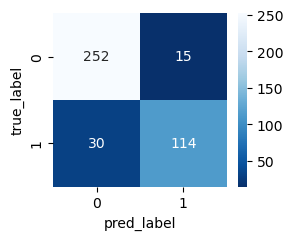

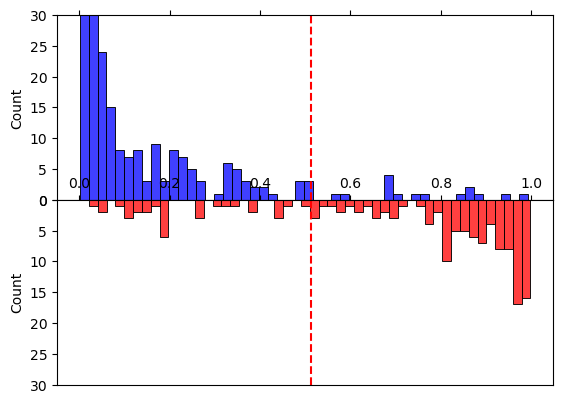

-- PS --
acc     :0.8807824100513992
f1      :0.8122769084938026
th      :0.4312499999999999
logloss :0.28491481889867165
DDepth_midPoint               :30.75
Lat_Bottom                    :24.0
Genus_ID                      :22.5
Temperature0_midPoint         :22.5
DDepth_Top                    :20.25
Lon0_Top                      :19.5
Com/Mat_F                     :19.5
Mat_M                         :17.5
Lat_Top                       :17.0
Food_Average                  :16.5
Habitat0_Average              :16.5
Lon0_Bottom                   :15.5
Av_M                          :14.75
Mat_F                         :14.5
Av_F                          :14.25
Mature_age                    :13.75
Behavior_Average              :13.0
Family_ID                     :12.25
NDepth_midPoint               :11.25
Associate_Large pelagics      :10.25
DDepth_Bottom                 :9.75
Aggregation0_Average          :9.0
Migration_Average             :8.75
Aggregation0_Top              :8.25
Associa

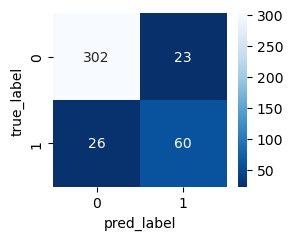

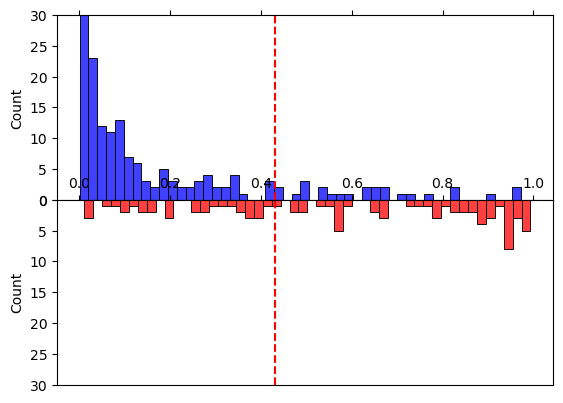

-- Others --
acc     :0.8952741290691034
f1      :0.7663593160824616
th      :0.49374999999999997
logloss :0.2973575531731141
Family_ID                     :10.0
NDepth_Bottom                 :7.0
Mat_F                         :6.75
Generation_top                :6.5
Commercial importance         :5.25
Lon1_Top                      :4.25
Mat_M                         :4.0
Av_F                          :4.0
Com/Mat_F                     :4.0
Habitat0_Average              :4.0
Occurrence                    :3.5
Migration_Average             :3.25
Associate_Floating object_duplicated_0:3.0
DDepth_midPoint               :2.75
Lat_Bottom                    :2.75
Lon0_Bottom                   :2.75
Genus_ID                      :2.5
Diel vertical migration       :2.5
Lon0_Top                      :2.25
Temperature_Bottom            :2.0
Behavior_Average              :2.0
Associate_Floating object     :2.0
Habitat0_Bottom               :1.75
DDepth_Bottom                 :1.5
Lat_Top         

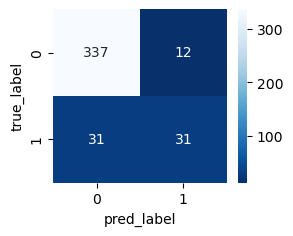

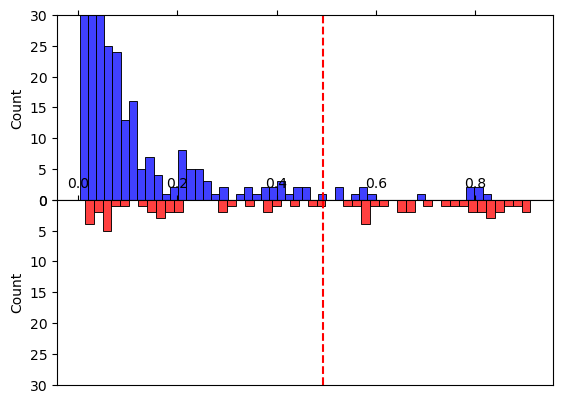

In [24]:
# Using scikit-learn API
df_probas = None

ths = []

for y_train, params in zip(ys_train, params_list):

    global x_train
    
    f = Scores()
    for ri in range(4):
        kf = KFold(n_splits=4, shuffle=True, random_state=ri)
        
        s = Scores()
        for fold, (train_indices, val_indices) in enumerate(kf.split(x_train)):
            x_train_f, x_val_f = x_train[train_indices], x_train[val_indices]
            y_train_f, y_val_f = y_train[train_indices], y_train[val_indices]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(x_train_f, y_train_f)
            
            y_proba = model.predict_proba(x_val_f)

            r = Result(y_val_f, y_proba, optimize=True)
            s["acc"].append(r.acc())
            s["f1"].append(r.f1())
            s["th"].append(r.th)
            s["logloss"].append(r.logloss())
            s["cm"].append(r.cm())
            s["proba"].append(r.proba)
            s["ind"].append(val_indices)
            s["feat_imp"].append(model.feature_importances_)
            

        f |= s.fold("ind", "cm", "proba")
    a = f.ave()

    ths.append(a["th"][0])


    print(f"-- {y_train.name} --")
    print(a)

    cf = {c: f for c, f in zip(x_train.columns, a["feat_imp"][0])}
    cf = {k: v for k, v in sorted(cf.items(), key=lambda item: item[1], reverse=True)}

    for c, f in cf.items():
        print(f"{c:30}:{f}")


    fig, ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(2.25)

    ax = sns.heatmap(a["cm"][0], annot=True, cbar=True, square=True, fmt=".0f", cmap="Blues_r", xticklabels=list(range(a["cm"][0].shape[0])), yticklabels=list(range(a["cm"][0].shape[1])))
    ax.set_xlabel("pred_label")
    ax.set_ylabel("true_label")


    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

    axs[0].set_ylim(0, 30)  # invert the axis
    sns.histplot(a["proba"][0][:, 1][y_train == 0], ax=axs[0], color='blue', bins=50)
    axs[0].xaxis.tick_top()  # and move the X-Axis

    axs[1].set_ylim(axs[0].get_ylim()[::-1])  # invert the axis
    sns.histplot(a["proba"][0][:, 1][y_train == 1], ax=axs[1], color='red', bins=50)
    axs[1].xaxis.tick_top()  # and move the X-Axis
    
    axs[0].axvline(x=a["th"][0], color='r', linestyle='--')
    axs[1].axvline(x=a["th"][0], color='r', linestyle='--')

# Remove space between subplots
    plt.subplots_adjust(hspace=0)

# Show the plot
    plt.show()


    df_proba = pl.Series(a["proba"][0][:, 1]).rename(y_train.name + "_prob").to_frame()
    df_proba = df_proba.with_columns(
        pl.when(pl.all() < a["th"][0])
        .then(pl.lit("N"))
        .otherwise(pl.lit("Y"))
        .name
        .map(lambda x: x[:-5] + "_pred")
    )
    if df_probas is None:
        df_probas = df_proba
    else:
        df_probas = pl.concat([df_probas, df_proba], how="horizontal")

df_pred_train = pl.concat([df_train, df_probas], how="horizontal")
# df_pred_train.write_csv("./prediction.csv")




In [23]:
# Using scikit-learn API
df_probas = None

for y_train, y_test, params, th in zip(ys_train, ys_test, params_list, ths):
    model = lgb.LGBMClassifier(**params)
    model.fit(x_train, y_train)

    y_proba = model.predict_proba(x_test)

    a_test = Scores()
    r = Result(y_test, y_proba)
    a_test["proba"].append(r.proba)

    df_proba = pl.Series(a_test["proba"][0][:, 1]).rename(y_test.name + "_prob").to_frame()
    df_proba = df_proba.with_columns(
        pl.when(pl.all() < th)
        .then(pl.lit("N"))
        .otherwise(pl.lit("Y"))
        .name
        .map(lambda x: x[:-5] + "_pred")

    )
    if df_probas is None:
        df_probas = df_proba
    else:
        df_probas = pl.concat([df_probas, df_proba], how="horizontal")

df_pred_test = pl.concat([df_test, df_probas], how="horizontal")


df_pred_test = pl.concat([df_pred_train, df_pred_test], how="vertical").sort("acceptedNameUsageID")
df_pred_test.write_csv("./prediction_nosize.csv")
